In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image, display
from sklearn.datasets import dump_svmlight_file
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from time import gmtime, strftime
import sys
import math
import json
import os 

In [100]:
# カルフォルニア大学アーバイン校の公開URLからデータセットをダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

--2019-08-05 12:57:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip.4’

bank-additional.zip 100%[===================>] 434.15K  1.37MB/s    in 0.3s    

2019-08-05 12:57:19 (1.37 MB/s) - ‘bank-additional.zip.4’ saved [444572/444572]

Archive:  bank-additional.zip
  inflating: bank-additional/.DS_Store  
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [101]:
# bank-additional-full.csvをdataへ格納
data = pd.read_csv('./bank-additional/bank-additional-full.csv', sep=';')
 
# 最初の10行を表示
data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


####	age：顧客の年齢
####	job：仕事のカテゴリ
####	marital：結婚ステータス
####	education：学歴
####	default：クレジットの支払遅延のステータス
####	housing：不動産ローンの有無
####	loan：パーソナルローンの有無
####	contact：銀行と顧客の連絡方法
####	month：最後に連絡をとった月
####	day_of_week：最後に連絡をとった曜日
####	duration：最後の連絡長さ（秒数）
####	campaign：このキャンペーン中に銀行が連絡した回数
####	pdays：最後のキャンペーンの連絡から経過した日にち
####	previous：このキャンペーン以前に銀行が連絡した回数
####	poutcome：前回のキャンペーンの結果
####	emp.var.rate：Employment Variation Rate
####	cons.price.idx：消費者物価指数
####	cons.conf.idx：消費者信頼感指数
####	euribor3m：3ヶ月スパンユーリボー指標金利
####	nr.employed：四半期の従業員数
####	y：顧客が定期預金を申し込みしたかどうか

In [102]:
data.shape

(41188, 21)

In [103]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [104]:
# データフレームの欠損データをまとめるテーブルの関数
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

# dataに欠損があるかどうか確認
missing_values_table(data)

,Missing Values,% of Total Values
age,0,0.0
job,0,0.0
marital,0,0.0
education,0,0.0
default,0,0.0
housing,0,0.0
loan,0,0.0
contact,0,0.0
month,0,0.0
day_of_week,0,0.0


In [105]:
# typeがobjcetの列に対して、各項目の度数分布の表を作成
for column in data.select_dtypes(include=['object']).columns:
  display(pd.crosstab(index=data[column], 
                      columns='% observations', 
                      normalize='columns'))

col_0,% observations
job,
admin.,0.253035
blue-collar,0.224677
entrepreneur,0.035350
housemaid,0.025736
management,0.070992
retired,0.041760
self-employed,0.034500
services,0.096363
student,0.021244


col_0,% observations
marital,
divorced,0.111974
married,0.605225
single,0.280859
unknown,0.001942


col_0,% observations
education,
basic.4y,0.101389
basic.6y,0.055647
basic.9y,0.146766
high.school,0.231014
illiterate,0.000437
professional.course,0.127294
university.degree,0.295426
unknown,0.042027


col_0,% observations
default,
no,0.791201
unknown,0.208726
yes,0.000073


col_0,% observations
housing,
no,0.452122
unknown,0.024036
yes,0.523842


col_0,% observations
loan,
no,0.824269
unknown,0.024036
yes,0.151695


col_0,% observations
contact,
cellular,0.634748
telephone,0.365252


col_0,% observations
month,
apr,0.063902
aug,0.149995
dec,0.004419
jul,0.174177
jun,0.129115
mar,0.013256
may,0.334296
nov,0.099568
oct,0.017432


col_0,% observations
day_of_week,
fri,0.190031
mon,0.206711
thu,0.209357
tue,0.196416
wed,0.197485


col_0,% observations
poutcome,
failure,0.103234
nonexistent,0.863431
success,0.033335


col_0,% observations
y,
no,0.887346
yes,0.112654


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


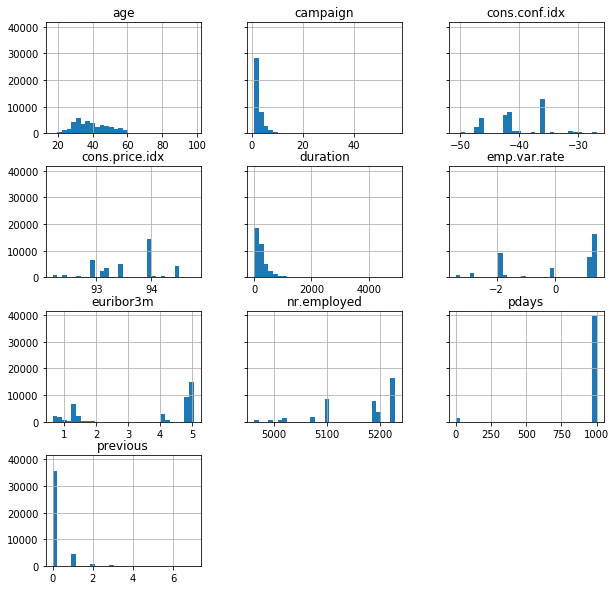

In [106]:
# 数値を値として持っている項目のヒストグラム
display(data.describe())

hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

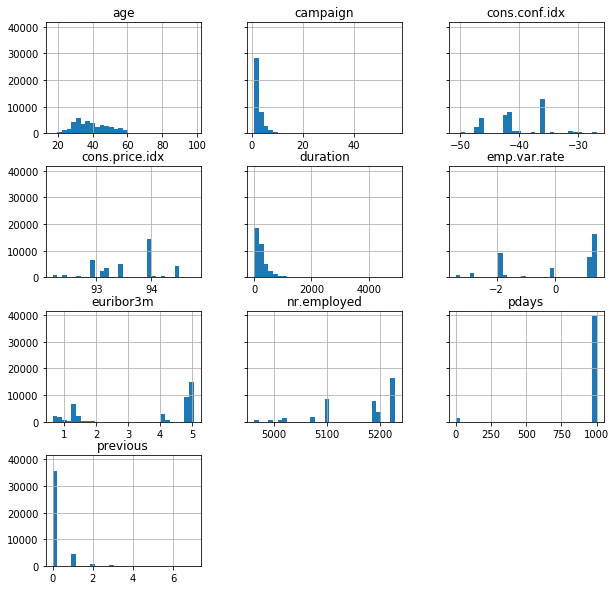

In [107]:
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

In [108]:
# 各項目が予測ターゲット「y」にどのように関係してるか確認 
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

y,no,yes
job,,
admin.,0.248167,0.291379
blue-collar,0.235745,0.137500
entrepreneur,0.036445,0.026724
housemaid,0.026103,0.022845
management,0.071030,0.070690
retired,0.035187,0.093534
self-employed,0.034804,0.032112
services,0.099759,0.069612
student,0.016417,0.059267


y,no,yes
marital,,
divorced,0.113166,0.102586
married,0.612783,0.545690
single,0.272190,0.349138
unknown,0.001861,0.002586


y,no,yes
education,,
basic.4y,0.102550,0.092241
basic.6y,0.057568,0.040517
basic.9y,0.152457,0.101940
high.school,0.232133,0.222198
illiterate,0.000383,0.000862
professional.course,0.127175,0.128233
university.degree,0.287239,0.359914
unknown,0.040495,0.054095


y,no,yes
default,,
no,0.776814,0.904526
unknown,0.223104,0.095474
yes,0.000082,0.000000


y,no,yes
housing,,
no,0.454088,0.436638
unknown,0.024160,0.023060
yes,0.521752,0.540302


y,no,yes
loan,,
no,0.823574,0.829741
unknown,0.024160,0.023060
yes,0.152266,0.147198


y,no,yes
contact,,
cellular,0.60991,0.830388
telephone,0.39009,0.169612


y,no,yes
month,,
apr,0.057267,0.116164
aug,0.151116,0.141164
dec,0.002545,0.019181
jul,0.178532,0.139871
jun,0.130212,0.120474
mar,0.007388,0.059483
may,0.352495,0.190948
nov,0.100826,0.089655
oct,0.011027,0.067888


y,no,yes
day_of_week,,
fri,0.191009,0.182328
mon,0.209779,0.182543
thu,0.207344,0.225216
tue,0.195277,0.205388
wed,0.196591,0.204526


y,no,yes
poutcome,,
failure,0.099787,0.130388
nonexistent,0.887107,0.676940
success,0.013106,0.192672


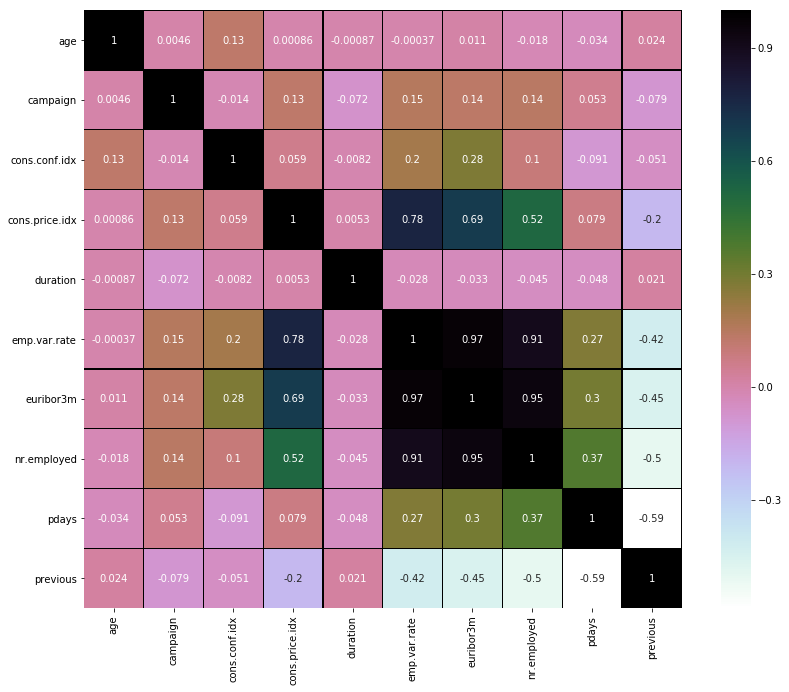

In [109]:
str_list = []
for colname, colvalue in data.iteritems():
    if type(colvalue[2]) == str:
         str_list.append(colname)

# 数値列を取得            
num_list = data.columns.difference(str_list) 

# 数値特徴のみを含むデータフレームを作成
data_num = data[num_list]
f, ax = plt.subplots(figsize=(14, 11))

# seabornを用いてヒートマップを描く
sns.heatmap(data_num.astype(float).corr(),linewidths=0.25,vmax=1.0, 
            square=True, cmap="cubehelix_r", linecolor='k', annot=True)


age


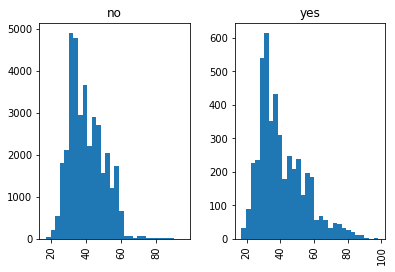

duration


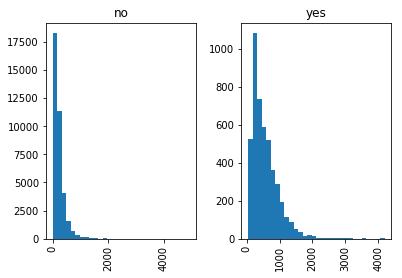

campaign


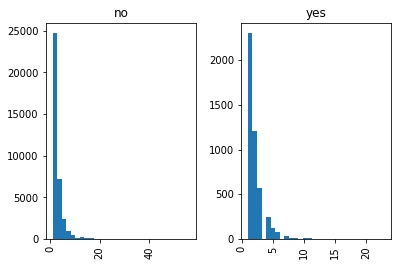

pdays


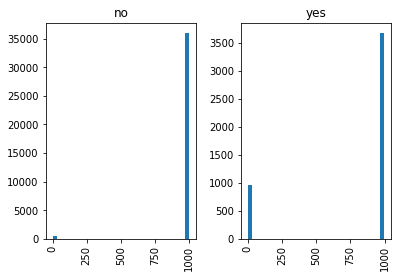

previous


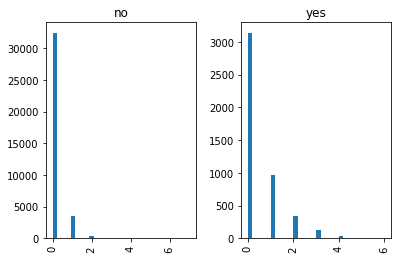

emp.var.rate


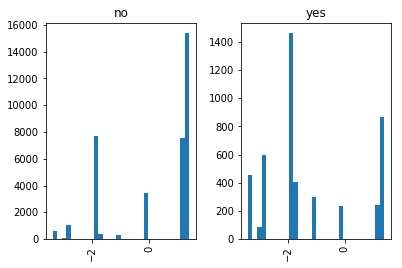

cons.price.idx


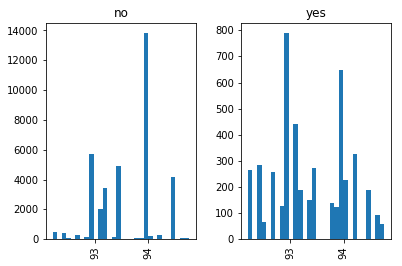

cons.conf.idx


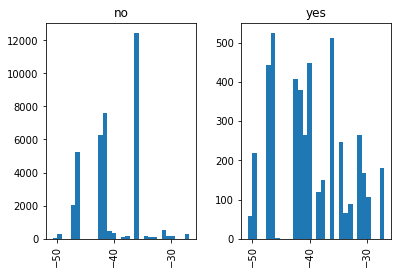

euribor3m


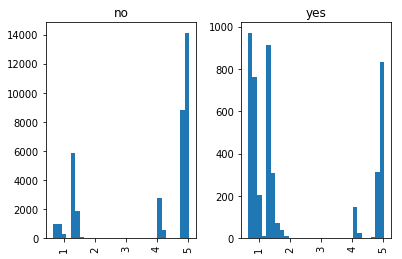

nr.employed


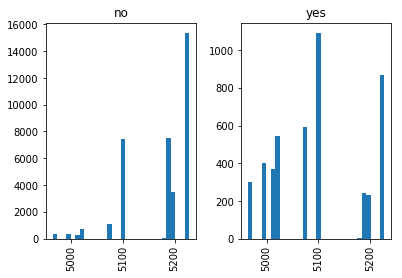

In [110]:
for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

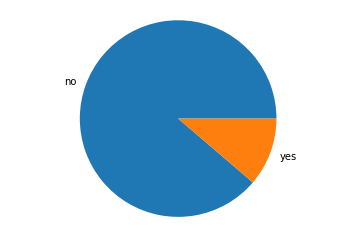

In [111]:
y_label = data['y'].value_counts(ascending=False, normalize=True).index
y_vals = data['y'].value_counts(ascending=False, normalize=True).values


plt.pie(y_vals, labels=y_label)
plt.axis('equal')
plt.show()

age


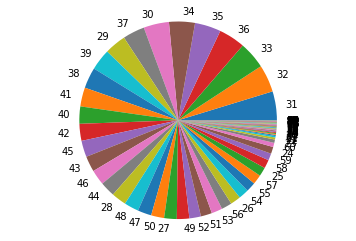

duration


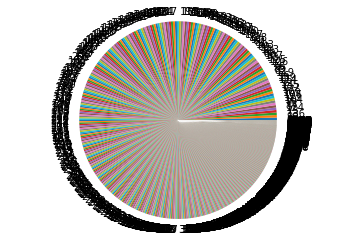

campaign


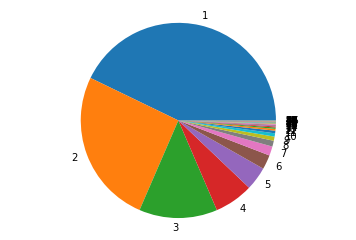

pdays


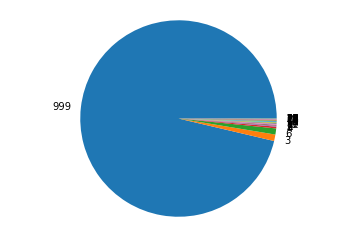

previous


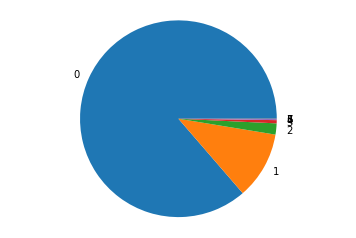

emp.var.rate


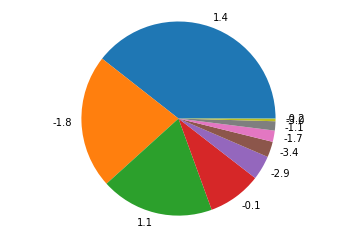

cons.price.idx


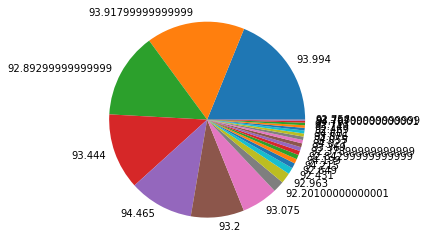

cons.conf.idx


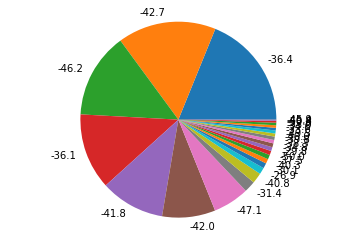

euribor3m


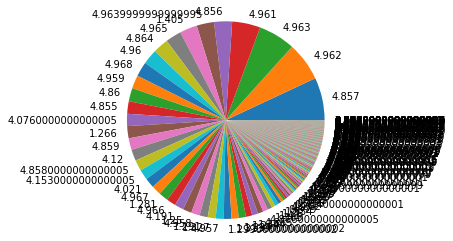

nr.employed


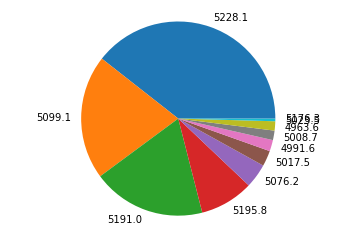

In [112]:
for column_name in data.select_dtypes(exclude=['object']).columns:
    print(column_name)
    job_label = data[column_name].value_counts(ascending=False, normalize=True).index
    job_vals = data[column_name].value_counts(ascending=False, normalize=True).values


    plt.pie(job_vals, labels=job_label)
    plt.axis('equal')
    plt.show()

In [113]:
y_label = data['age_group'].value_counts(ascending=False, normalize=True).index
y_vals = data['age_group'].value_counts(ascending=False, normalize=True).values


plt.pie(y_vals, labels=y_label)
plt.axis('equal')
plt.show()

KeyError: ignored

In [0]:
for column_name in data.select_dtypes(include=['object']).columns:
    print(column_name)
    job_label = data[column_name].value_counts(ascending=False, normalize=True).index
    job_vals = data[column_name].value_counts(ascending=False, normalize=True).values


    plt.pie(job_vals, labels=job_label)
    plt.axis('equal')
    plt.show()

In [0]:
# 箱ひげ
y_yes = data[data['y'] == 'yes']
y_no = data[data['y'] == 'no']
y_age = [y_yes['age'], y_no['age']]

plt.boxplot(y_age)
plt.xlabel('y')
plt.ylabel('age')
ax = plt.gca()
plt.setp(ax, xticklabels = ['yes', 'n'])


In [0]:
y_yes = data[data['y'] == 'yes']
y_no = data[data['y'] == 'no']
for column_name in data.select_dtypes(include=['int64','float64']).columns:
  print(column_name)
  y_column_name = [y_yes[column_name], y_no[column_name]]

  plt.boxplot(y_column_name)
  plt.xlabel('y')
  plt.ylabel('age')
  ax = plt.gca()
  plt.setp(ax, xticklabels = ['yes', 'no'])
  plt.show()

In [0]:
# 相関係数とScatter Matrixの確認
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

In [0]:
# 以前にコンタクトがなかった人を判別する新しい項目の追加
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0)
 
# 職業から「職についていない人」（学生など）のフラグを追加
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)

In [114]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [0]:
data['job_flag'] = 'not-working'
data.loc[(data['job'] == 'managemant')   | 
         (data['job'] == 'technician')   |
         (data['job'] == 'blue-collar')  |
         (data['job'] == 'admin')        |
         (data['job'] == 'services')     |
         (data['job'] == 'self-employed')|
         (data['job'] == 'entrepreneur') |
         (data['job'] == 'housemaid'), 'job_flag'] = 'worker'

In [0]:
data.loc[(data['month'] == 'jan')  | 
         (data['month'] == 'feb')  |
         (data['month'] == 'mar'), 'quarter'] = '1Q'

data.loc[(data['month'] == 'apr')  | 
         (data['month'] == 'may')  |
         (data['month'] == 'jun'), 'quarter'] = '2Q'

data.loc[(data['month'] == 'jul')  | 
         (data['month'] == 'aug')  |
         (data['month'] == 'sep'), 'quarter'] = '3Q'

data.loc[(data['month'] == 'oct')  | 
         (data['month'] == 'nov')  |
         (data['month'] == 'dec'), 'quarter'] = '4Q'

In [0]:
data.loc[data['previous'] == 0, 'previous_flg' ] = 0
data.loc[data['previous'] >= 1, 'previous_flg' ] = 1

In [0]:
duration_mean = data['duration'].mean()
data.loc[data['duration'] <= duration_mean, 'duration_flg' ] = 'short'
data.loc[data['duration'] > duration_mean,  'duration_flg' ] = 'long'

In [0]:
age_bin = np.arange(0, 101, 10)
age_cut_data = pd.cut(data["age"], age_bin.tolist())
age_group_name = ['0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
age_cut_data = pd.cut(data["age"], age_bin.tolist(), labels=age_group_name)
data['age_group'] = age_cut_data

In [0]:
# 項目を削除
droped_data = data.drop(['age','job','month','duration', 'previous'], axis=1)

In [0]:
str_list = []
for colname, colvalue in droped_data.iteritems():
    if type(colvalue[2]) == str:
         str_list.append(colname)

# 数値列を取得            
num_list = droped_data.columns.difference(str_list) 

# 数値特徴のみを含むデータフレームを作成
data_num = droped_data[num_list]
f, ax = plt.subplots(figsize=(14, 11))

# seabornを用いてヒートマップを描く
sns.heatmap(data_num.astype(float).corr(),linewidths=0.25,vmax=1.0, 
            square=True, cmap="cubehelix_r", linecolor='k', annot=True)

In [121]:
droped_data.columns

Index(['marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day_of_week', 'campaign', 'pdays', 'poutcome', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_flag', 'quarter', 'previous_flg', 'duration_flg', 'age_group'],
      dtype='object')

In [0]:
# カテゴリカルデータをダミー変数化
model_data = pd.get_dummies(droped_data)

In [42]:
# 項目を削除
# model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 
#                               'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

KeyError: ignored

In [123]:
# データを確認
model_data.head(10)

,campaign,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,previous_flg,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes,job_flag_not-working,job_flag_worker,quarter_1Q,quarter_2Q,quarter_3Q,quarter_4Q,duration_flg_long,duration_flg_short,age_group_0s,age_group_10s,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90s
0,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
6,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
7,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
8,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
9,1,999,1.1,93.994,-36.4,4.857,5191.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [0]:
X = model_data.drop(['y_no', 'y_yes'], axis=1)
y = model_data[['y_no', 'y_yes']]

In [92]:
y['y'] = model_data[['y_yes']]
y = y.drop(['y_yes', 'y_no'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [93]:
y.head(10)

,y
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)

In [0]:
import xgboost as xgb
model = xgb.XGBClassifier(
    eta = 0.02,
    min_child_weight= 2,
    max_depth= 4,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    Lambda=0.4,
    alpha=0.4,
    scale_pos_weight=1,
    objective= 'binary:logistic',
    eval_metric = 'rmse',
    random_state=0
)


In [127]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [128]:
model.score(X_train, y_train)

0.9889057494520317

In [129]:
model.score(X_test, y_test)

0.8570041272153436

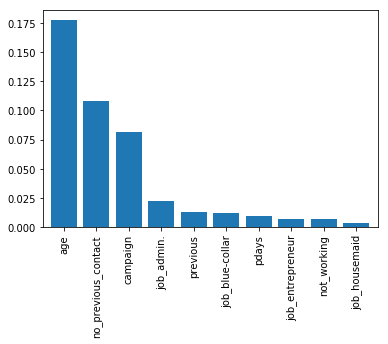

In [43]:
# モデル構築の中でどの変数が重要な役割を担ったのかを定量的に把握する
s = pd.Series(model.feature_importances_, 
              index=X_test.columns )

# 取得した値を降順に表示
s[:10].sort_values(ascending=False).plot.bar(width=0.8,color='C0')

In [0]:
#data['job2'] = 'not_worker'

In [69]:
data.loc[(data['job'] == 'managemant')   | 
         (data['job'] == 'technician')   |
         (data['job'] == 'blue-collar')  |
         (data['job'] == 'admin')        |
         (data['job'] == 'services')     |
         (data['job'] == 'self-employed')|
         (data['job'] == 'entrepreneur') |
         (data['job'] == 'housemaid'), 'job2'] = 'worker'

data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,no_previous_contact,not_working,job2
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,1,0,worker
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,1,0,worker
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30s,1,0,worker
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30s,1,0,not_worker
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,1,0,worker


In [70]:
data.loc[(data['month'] == 'jan')  | 
         (data['month'] == 'feb')  |
         (data['month'] == 'mar'), 'month2'] = '1Q'

data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,no_previous_contact,not_working,job2,month2
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,1,0,worker,NaN
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,1,0,worker,NaN
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30s,1,0,worker,NaN
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30s,1,0,not_worker,NaN
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,1,0,worker,NaN


In [79]:
data.groupby('month').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_previous_contact,not_working
month,,,,,,,,,,,,
apr,40.593845,293.200608,1.947188,955.587386,0.323328,-1.800000,93.119558,-46.273632,1.361070,5093.123708,0.956307,0.120441
aug,41.644221,232.430722,2.666559,961.062156,0.115410,0.747151,93.311065,-35.597184,4.300623,5200.248349,0.961800,0.093720
dec,47.307692,345.609890,2.159341,748.060440,0.615385,-2.846154,92.715363,-33.708791,0.865319,5031.895604,0.747253,0.346154
jul,39.035545,273.426122,3.160998,982.700725,0.047115,1.158921,93.894923,-42.370170,4.685678,5214.078575,0.983552,0.075411
jun,39.766077,242.561301,3.072208,970.221512,0.083114,0.688379,94.245402,-41.579428,4.256908,5197.493193,0.971042,0.083490
mar,40.778388,245.946886,2.203297,835.454212,0.483516,-1.800000,93.097330,-42.650549,1.162745,5055.390110,0.835165,0.225275
may,39.031084,261.231752,2.439756,981.120415,0.164209,-0.164972,93.528882,-40.579272,3.293665,5149.521592,0.981989,0.059917
nov,40.965618,245.855645,1.909290,952.950256,0.293587,-0.418483,93.200943,-41.238747,3.723123,5173.031236,0.953670,0.083882
oct,44.171309,288.367688,1.545961,781.909471,0.647632,-2.438579,93.175107,-34.580919,1.200123,5018.823816,0.781337,0.288301


In [43]:
data.loc[(data['month'] == 'ap')  | 
         (data['month'] == 'feb')  |
         (data['month'] == 'mar'), 'quarter'] = '1Q'

data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,quarter
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,NaN
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,NaN
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30s,NaN
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30s,NaN
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,NaN


In [44]:
data.loc[(data['month'] == 'apr')  | 
         (data['month'] == 'may')  |
         (data['month'] == 'jun'), 'quarter'] = '2Q'

data.loc[(data['month'] == 'jul')  | 
         (data['month'] == 'aug')  |
         (data['month'] == 'sep'), 'quarter'] = '3Q'

data.loc[(data['month'] == 'oct')  | 
         (data['month'] == 'nov')  |
         (data['month'] == 'dec'), 'quarter'] = '4Q'

data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,quarter
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,2Q
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,2Q
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30s,2Q
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,30s,2Q
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,50s,2Q


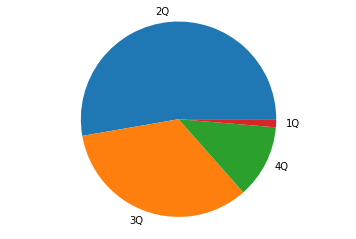

In [45]:
y_label = data['quarter'].value_counts(ascending=False, normalize=True).index
y_vals = data['quarter'].value_counts(ascending=False, normalize=True).values


plt.pie(y_vals, labels=y_label)
plt.axis('equal')
plt.show()

## 演習　Q１．1日～10日を「early」、11日～20日を「middle」、21日～31日を「late」として、月中の期間を表わす「month-term」を作成して下さい。

In [46]:
data.loc[data['day'] <= 10, 'month-term' ] = 'early'
data.loc[data['day'] <= 10, 'month-term' ] = 'middle'
data.loc[data['day'] <= 10, 'month-term' ] = 'late'

KeyError: ignored

## 演習

## キャンペーン以前に銀行が連絡した回数を示す「previous」について、連絡なしの場合を「0」、連絡が１回以上されている場合を「1」とする新しい項目「previous_flg」を作成して下さい。

In [0]:
data.loc[data['previous'] == 0, 'previous_flg' ] = 0
data.loc[data['previous'] >= 1, 'previous_flg' ] = 1

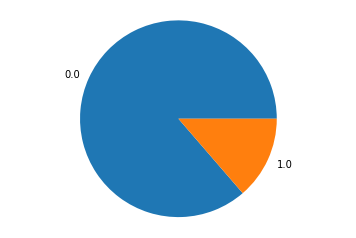

In [56]:
y_label = data['previous_flg'].value_counts(ascending=False, normalize=True).index
y_vals = data['previous_flg'].value_counts(ascending=False, normalize=True).values


plt.pie(y_vals, labels=y_label)
plt.axis('equal')
plt.show()

## 演習

## 通話時間「duration」の平均値を求めて、平均値以下の通話時間を「short」、平均値より長い通話時間を「long」として、新しい項目「duration_flg」を作成して下さい。

In [0]:
duration_mean = data['duration'].mean()

In [0]:
data.loc[data['duration'] <= duration_mean, 'duration_flg' ] = 'short'
data.loc[data['duration'] > duration_mean,  'duration_flg' ] = 'long'

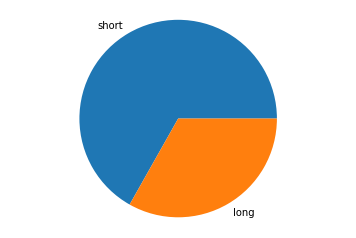

In [50]:
y_label = data['duration_flg'].value_counts(ascending=False, normalize=True).index
y_vals = data['duration_flg'].value_counts(ascending=False, normalize=True).values


plt.pie(y_vals, labels=y_label)
plt.axis('equal')
plt.show()

In [0]:
# 項目を削除
model_data = model_data.drop(['age'], axis=1)

In [0]:
X = model_data.drop(['y_no', 'y_yes'], axis=1)
y = model_data[['y_no', 'y_yes']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [96]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [97]:
model.score(X_train, y_train)

1.0

In [98]:
model.score(X_test, y_test)

0.8850449138140325

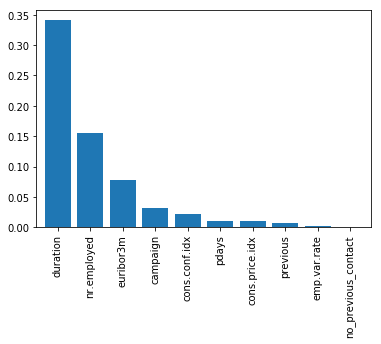

In [99]:
# モデル構築の中でどの変数が重要な役割を担ったのかを定量的に把握する
s = pd.Series(model.feature_importances_, 
              index=X_test.columns )

# 取得した値を降順に表示
s[:10].sort_values(ascending=False).plot.bar(width=0.8,color='C0')